<a href="https://colab.research.google.com/github/UrumeseJoy/ml-projects/blob/main/EATRIGHT_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving eatdata.xlsx to eatdata.xlsx
Saving messmenu.xlsx to messmenu.xlsx


In [ ]:
import re

ignore_foods = [
    "rice", "phulka", "chapathi", "tea", "snacks", "fruits", "fruit",
    "boiled egg", "chocos", "cornflakes", "rasam", "sambar", "sambhar",
    "buttermilk", "jam", "boiled chole", "omelette", "curd", "boiled green gram",
    "biscuit", "rusk", "milk", "coffee", "dal", "egg", "sprout",
    "sauce", "tomato sauce", "boiled black channa", "boiled black chana", "imli chutney",
    "green chutney", "vada curry", "boiled moong", "boiled white peas",
    "pudina chutney", "coconut chutney", "white chana sprouts", "vada", "dosa", "idly",
    "idly [a]", "rava idly [c]", "kal dosa", "rava dosa",
    "idly [a]/rava idly [c]", "plain dosa", "plain dosa (c)", "onion dosa", "onion dosa (c)",
    "groundnut chutney", "red chilli chutney", "boiled peanut", "millet sprouts",
    "tindly fry", "paodi type", "drumstick[a]/brinjal[c]curry", "boiled sweet corn",
    "kara kuzhambu"
]

def is_unique(food):
    food_lower = food.lower()
    return not any(re.search(rf"\b{re.escape(common.strip())}\b", food_lower) for common in ignore_foods)


In [ ]:
import pandas as pd

menu_df = pd.read_excel('messmenu.xlsx', engine='openpyxl')
eat_df = pd.read_excel('eatdata.xlsx', engine='openpyxl')


In [ ]:
WEEK_SEQUENCE = ['B', 'C', 'D', 'A']
DAYS = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
MEALS = ['Breakfast', 'Lunch', 'Dinner']

# Build menu mapping by region, week, meal, day
menus = {}
for region in menu_df['Menu_Type'].unique():
    menus[region] = {}
    for week in WEEK_SEQUENCE:
        menus[region][week] = {}
        for meal in MEALS:
            menus[region][week][meal] = {}
            for day in DAYS:
                menu_rows = menu_df[
                    (menu_df['Menu_Type'] == region) &
                    (menu_df['Meal'] == meal) &
                    (menu_df['Week'].str.contains(week))
                ]
                if not menu_rows.empty:
                    menu_row = menu_rows.iloc[0]
                    raw_items = menu_row[day].split(",")
                    cleaned_items = [f.strip() for f in raw_items if is_unique(f)]
                    menus[region][week][meal][day.upper()] = cleaned_items
                else:
                    menus[region][week][meal][day.upper()] = []


In [ ]:
def get_prev_week(current_week):
    idx = WEEK_SEQUENCE.index(current_week)
    return WEEK_SEQUENCE[idx - 1] if idx > 0 else WEEK_SEQUENCE[-1]

def get_prev_day(day):
    idx = DAYS.index(day.capitalize())
    return DAYS[idx - 1].upper() if idx > 0 else "SUNDAY"

def get_prev_foods_all_meals(row):
    region = row['Region']
    prev_week = get_prev_week(row['Week'])
    prev_day = get_prev_day(row['Day'])
    foods = []
    for meal in MEALS:
        foods.extend(menus.get(region, {}).get(prev_week, {}).get(meal, {}).get(prev_day, []))
    return foods

eat_df['Prev_Week'] = eat_df['Week'].apply(get_prev_week)
eat_df['Prev_Day'] = eat_df['Day'].apply(get_prev_day)
eat_df['Prev_Foods'] = eat_df.apply(get_prev_foods_all_meals, axis=1)

# Optional: Check the mapping
eat_df[['Day', 'Week', 'Region', 'Prev_Day', 'Prev_Week', 'Prev_Foods']].head()


,Day,Week,Region,Prev_Day,Prev_Week,Prev_Foods
0,SATURDAY,B,North,FRIDAY,A,"[Semiya Khichdi, Karela fry, Aloo Palak (gravy..."
1,SUNDAY,B,North,SATURDAY,A,"[Aloo Paratha, Green Methi Paratha, Aloo 65, R..."
2,MONDAY,B,North,SUNDAY,A,"[Mixed boiled sprouts, Onion Tomato Chutney, H..."
3,TUESDAY,B,North,MONDAY,A,"[Poha, Tamarind Chutney, Jalebi, Gobi Capsicum..."
4,WEDNESDAY,B,North,TUESDAY,A,"[Rava Upma, Kachori, Aloo Sabji, Bhindi Aloo B..."


In [ ]:
food_risk = []
for _, row in eat_df.iterrows():
    score = 1.0 if row['Stomach Issues'] == 'Y' else 0.0
    if isinstance(row['Stomach Issues'], float):
        score = float(row['Stomach Issues'])
    for food in row['Prev_Foods']:
        food_risk.append((food, score))

risk_df = pd.DataFrame(food_risk, columns=['Food', 'Score'])
food_scores = risk_df.groupby('Food')['Score'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
food_scores = food_scores.rename(columns={'mean': 'Average_Risk', 'count': 'Occurrences'})

# Display the top risky foods
food_scores.head(10)


,Average_Risk,Occurrences
Food,,
Aloo 65,0.250000,2
Aloo Paratha,0.250000,2
Tawa mix veg sabji,0.250000,2
Ridge gourd Channa Masala,0.250000,2
Green Methi Paratha,0.250000,2
Chole Bhature,0.090000,5
Tomato Peas Curry,0.090000,5
Tomato pappu[A]/Tindly Kara pappu [C],0.090000,5
Tamarind pulihora,0.090000,5


<ipython-input-7-cbd6a22822ff>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Average_Risk', y='Food', data=top_foods, palette='Reds_d')


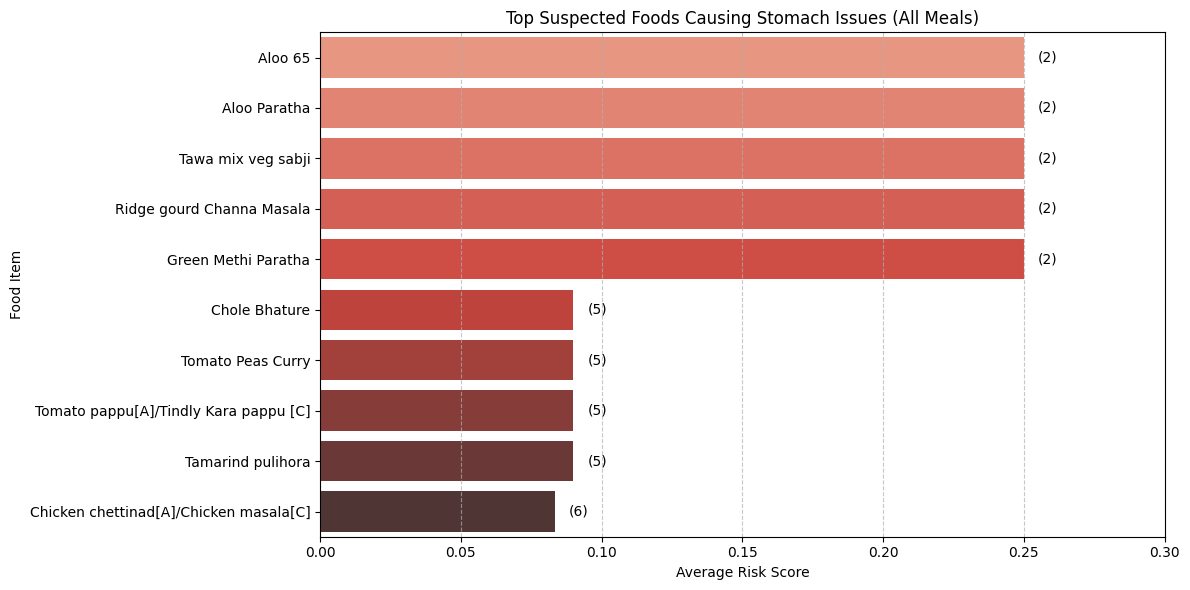

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

top_foods = food_scores.reset_index().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='Average_Risk', y='Food', data=top_foods, palette='Reds_d')

for index, row in top_foods.iterrows():
    plt.text(row['Average_Risk'] + 0.005, index, f"({int(row['Occurrences'])})", va='center')

plt.title('Top Suspected Foods Causing Stomach Issues (All Meals)')
plt.xlabel('Average Risk Score')
plt.ylabel('Food Item')
plt.xlim(0, max(top_foods['Average_Risk']) + 0.05)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
